   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[I 2024-11-11 14:45:13,915] A new study created in memory with name: no-name-51927791-f15f-45c7-afe8-4f95378ef577
[I 2024-11-11 14:45:15,342] Trial 0 finished with value: 0.10394390639730211 and parameters: {'n_estimators': 214, 'learning_rate': 0.06987618586724864, 'max_depth': 6, 'subsample': 0.8005697576115638}. Best is trial 0 with value: 0.10394390639730211.
[I 2024-11-11 14:45:16,295] Trial 1 finished with value: 0.08242123276044297 and parameters: {'n_estimators': 169, 'learning_rate': 0.18337738025131606, 'max_depth': 6, 'subsample': 0.6363540994256793}. Best is trial 1 with value: 0.08242123276044297.
[I 2024-11-11 14:45:17,053] Trial 2 finished with value: 0.23569062550596612 and parameters: {'n_estimators': 272, 'learning_rate': 0.1462380432231295, 'max_depth': 2, 'subsample': 0.6102509884750541}. Best is trial 1 with value: 0.08242123276044297.
[I 2024-11-11 14:45:17,480] Trial 3 finished with value: 5.314556102634457 and parameters: {'n_estimators': 60, 'learning_rate': 0.

+--------------------------------+----------+----------+
| Model                          |      MSE |       R² |
+================================+==========+==========+
| Gradient Boosting (GridSearch) | 0.136271 | 0.993660 |
+--------------------------------+----------+----------+
| Gradient Boosting (Optuna)     | 0.070008 | 0.996743 |
+--------------------------------+----------+----------+


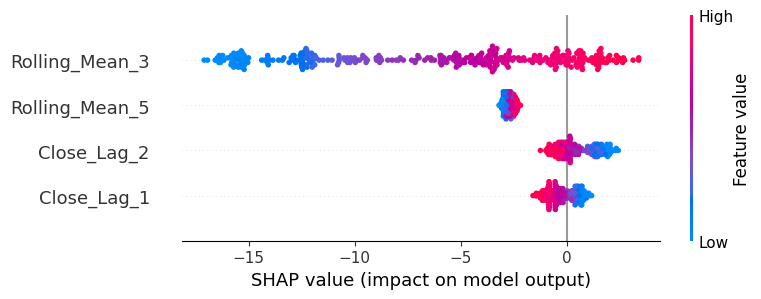

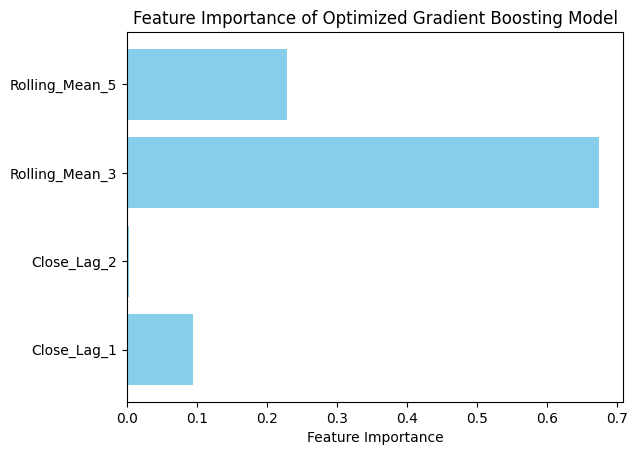

In [ ]:
!pip install optuna shap

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import optuna
import shap

df = pd.read_csv('/content/Золото.csv')

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Используем только переменную 'Close'
df = df[['Date', 'Close']].dropna()

# Создание лагов и скользящих статистик
df['Close_Lag_1'] = df['Close'].shift(1)
df['Close_Lag_2'] = df['Close'].shift(2)
df['Rolling_Mean_3'] = df['Close'].rolling(window=3).mean()
df['Rolling_Mean_5'] = df['Close'].rolling(window=5).mean()

# Удаление строк с NaN, возникших при создании лагов и скользящих средних
df = df.dropna()

# Разделение данных на признаки и целевую переменную
features = ['Close_Lag_1', 'Close_Lag_2', 'Rolling_Mean_3', 'Rolling_Mean_5']
X = df[features]
y = df['Close']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 2. Базовая модель: Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# 3. Подбор гиперпараметров с GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_gbr = grid_search.best_estimator_
y_pred_best_gbr = best_gbr.predict(X_test)
gbr_mse = mean_squared_error(y_test, y_pred_best_gbr)
gbr_r2 = r2_score(y_test, y_pred_best_gbr)

# 4. Подбор гиперпараметров с Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0)
    }

    model = GradientBoostingRegressor(random_state=42, **param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params_optuna = study.best_params
optuna_gbr = GradientBoostingRegressor(random_state=42, **best_params_optuna)
optuna_gbr.fit(X_train, y_train)

y_pred_optuna_gbr = optuna_gbr.predict(X_test)
optuna_gbr_mse = mean_squared_error(y_test, y_pred_optuna_gbr)
optuna_gbr_r2 = r2_score(y_test, y_pred_optuna_gbr)

# 5. Вывод результатов
results = [
    ['Gradient Boosting (GridSearch)', gbr_mse, gbr_r2],
    ['Gradient Boosting (Optuna)', optuna_gbr_mse, optuna_gbr_r2]
]

headers = ['Model', 'MSE', 'R²']
print(tabulate(results, headers=headers, tablefmt='grid', floatfmt=".6f"))

# 6. Интерпретация модели с использованием SHAP
explainer = shap.Explainer(optuna_gbr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# 7. График важности признаков (барплот)
feature_importance = optuna_gbr.feature_importances_
plt.barh(X_train.columns, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Optimized Gradient Boosting Model")
plt.show()

# Воспроизводимость решения обеспечена с использованием random_state=42.

Feature Importances:
Close_Lag_1: 0.0944
Close_Lag_2: 0.0023
Rolling_Mean_3: 0.6747
Rolling_Mean_5: 0.2286


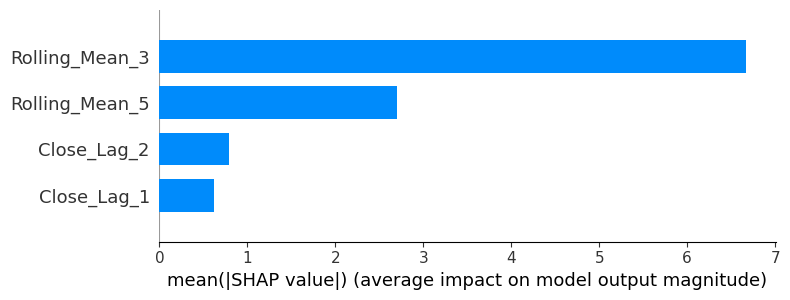

In [ ]:
print("Feature Importances:")
for feature, importance in zip(features, optuna_gbr.feature_importances_):
    print(f"{feature}: {importance:.4f}")

explainer = shap.Explainer(optuna_gbr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")